***...THIS IS A DEFINETLY A NOTEBOOK...***

*Check and update 'init.py' script with dataset specific informations. It functions as a main dictionary for all the scripts.*

*Open the script in a text editor to read more.*

**Load the main dictionary**

In [ ]:
from init import get_maind

maind = get_maind(save = True)

**Transform data in evoked format for easier data fetching launching the 'toMNE.py' script in the terminal**

**After data conversion compute observables with following scripts**

*   corrsum.py : Computes Correlation Sum $C(m,r)$ for different embedding dimensions $m$ and scales $r$

*   idim.py : Computes Information Dimension $D_{2}(m)$ for different embedding dimensions $m$ fitting results of corrsum.py script

*   llyap.py : Computes Largest Lyapunov Exponent $\lambda(m)$ for different embedding dimensions $m$

**Following observable computation data can be plotted using the following wrapper**

{'tau': 40, 'avT': None, 'lenght': 10, 'window': [0, 1], 'clustered': False, 'subjects': ['000'], 'conditions': ['lorenz'], 'pois': [0], 'embeddings': [2, 3, 4, 5, 6, 7, 8, 9], 'shape': [3, 1, 1, 1, 8]}
(1, 1, 1, 8)


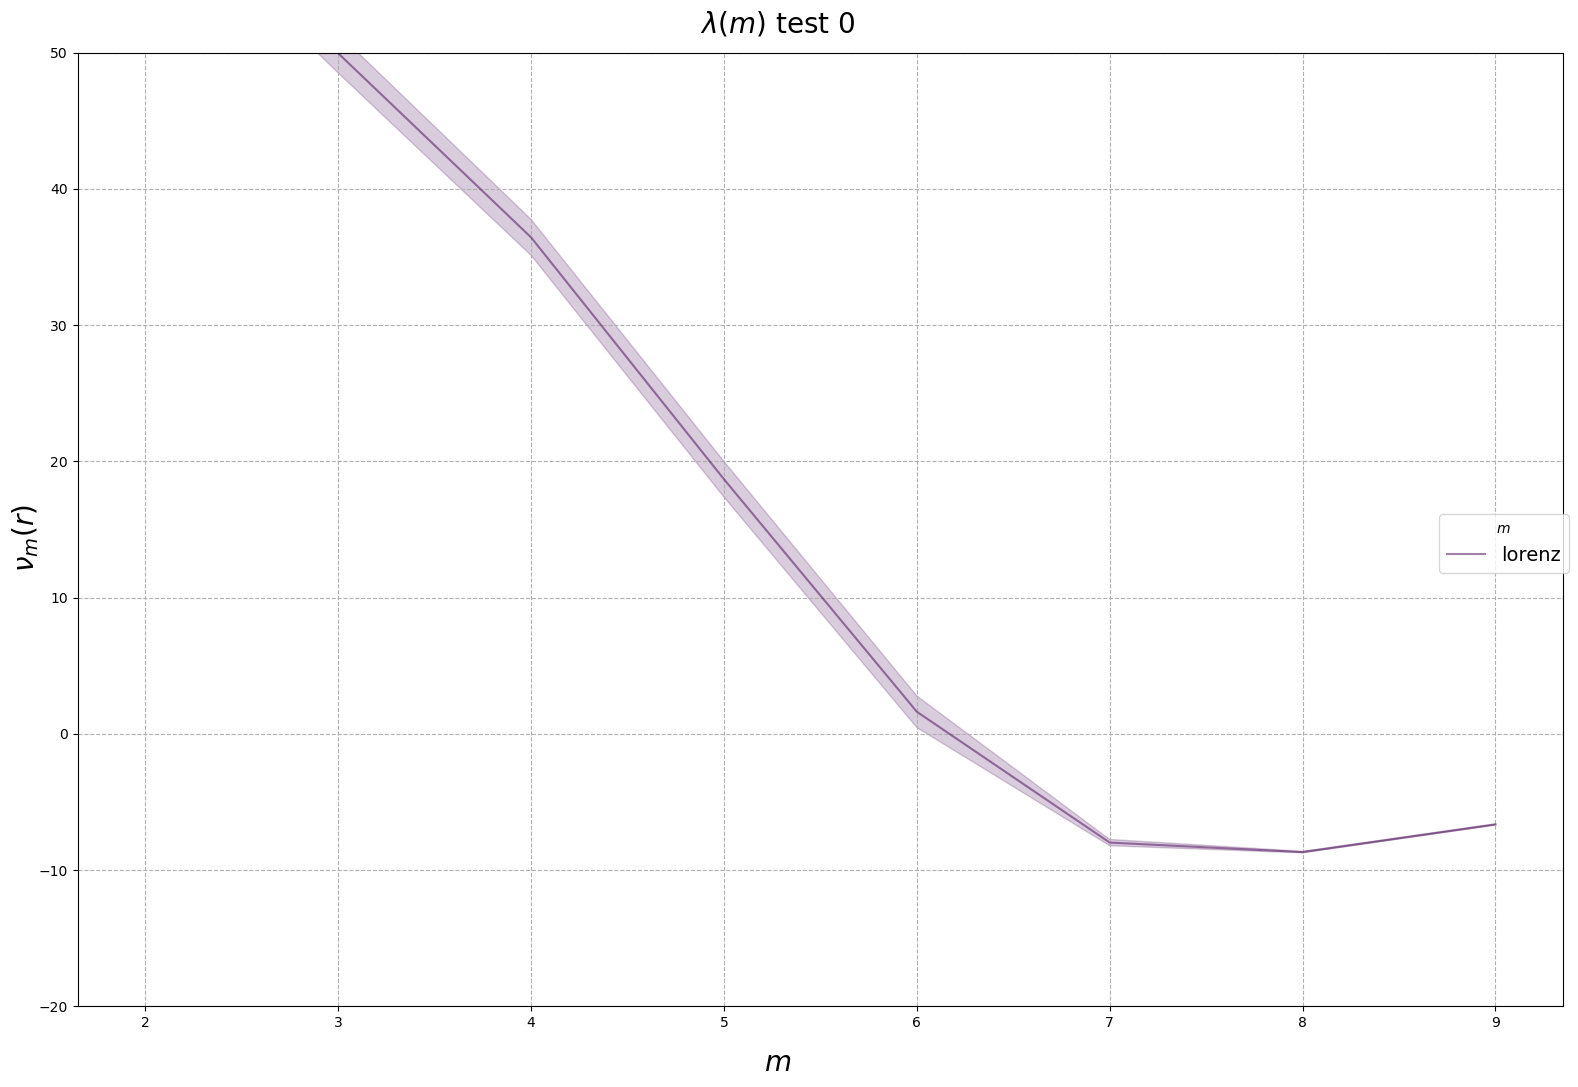

In [9]:
# Print data with wrapper

# Info dictionary about observable
info = {
    'exp_name': 'lorenz',
    'avg_trials': True,
    'obs_name': 'llyap',
    'clust_lb': 'noisefree',
    'calc_lb': None,
    'compound_error': True
}

# Instructions dictionary for plotting
instructions = {
    'figure': 'pois',
    'multiplot': 'subjects',
    'legend': 'conditions',
    'axis': 'embeddings',
    'avg': 'none',
    'reduce_method': 'product',
    'ylabel': '$\\nu_{m}(r)$',
    'ylim': (-20,50),
    'alpha_m': 0.5,
    'grid': (1,1),
    'showgrid': True,
    'figsize': (16,11),
    'textsz': 20,
    'legend_t': '$m$'
}

# Launch the wrapper (STILL UNDER WORK)
from plotting import plot_observable

plot_observable(info = info, instructions = instructions, show = True, save = True, verbose = True)

***BELOW YET TO BE WRAPPED GRAPHICS***

*(very flimsy code)*

**Check $C(m,r)$ very average behaviour**

For new results, edit the script and run *'python -m corrsum'* in the console.

**Load Backward Masking dataset infos**

In [ ]:
#Data paths

# Dataset name
exp_name = 'bmasking'

#Workflow folder path
wf_path = maind['path']

#Backward Masking dataset path
bw_path = maind[exp_name]['directories']['rw_data']

#Channel names
ch_list = maind[exp_name]['pois']

# Useful clusters

# Parieto-Occipital and Frontal
ch_clust = ['O2','PO4','PO8'],['Fp1','Fp2','Fpz']

**Load 'corrsum.py' script results**

In [ ]:
# Load results of corrsum.py script

# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

lb = 'G'

# Load results from correlation.py script
CS = np.load(wf_path + 'results/avg/BM/' + lb + '/CS/CSums.npy')
r = np.load(wf_path + 'results/avg/BM/' + lb + '/CS/rvals.npy')

print(CS.shape)

with open(wf_path + 'results/avg/BM/' + lb + '/CS/variables.json', 'r') as f:
    vars = json.load(f)

embs = vars['embeddings']

**Plot the most average data you can think of**

In [ ]:
# Average data and print plots with std error area

# Get average across subjects across channels (for now)
CS = CS.mean(axis = 0)

CScon = CS[0,:,:,:]
CSunc = CS[1,:,:,:]

CScon_std = CScon.std(axis = 0)
CSunc_std = CSunc.std(axis = 0)

CScon = CScon.mean(axis = 0)
CSunc = CSunc.mean(axis = 0)

fig, axs = plt.subplots(1,2, figsize = (15,10), dpi = 300)

for i, c in enumerate(CScon):
    axs[0].plot(r, c, marker = 'o', markersize = 2, linewidth = 0.5, label = 'm = ' + str(embs[i]))
    axs[0].fill_between(r, c - CScon_std[i,:],c + CScon_std[i,:], alpha = 0.2)

axs[0].set_title('Conscious presentation')

for i, c in enumerate(CSunc):
    axs[1].plot(r, c, marker = 'o', markersize = 2, linewidth = 0.5)#, label = 'm = ' + str(embs[i]))
    axs[1].fill_between(r, c - CSunc_std[i,:],c + CSunc_std[i,:], alpha = 0.2)

axs[1].set_title('Masked presentation')

for ax in axs:
    ax.grid()

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('$r$')
    ax.set_ylabel('$C(m,r)$')

fig.legend(loc = 'center right')
plt.savefig(wf_path + 'pics/BM/' +  lb + '_averageCsum.png', dpi = 300)
plt.show()

**Select just for Parieto-Occipital and Frontal electrodes**

*Run this cell if global correlation sum is already calculated or a launch new script (slower and could differ for averaging method)*

In [ ]:
# Load global results for reducing over clusters

# Experiment name
exp_name = 'bmasking'

# Trial-wise averaging
avg_trials = True

# Average results
average = True

# Dedicated function for Correlation Sum results (Will be generalized with obs_name variable)
from core import reduceCS

# Parieto-Occipital electrodes
lb = 'PO'
pois = ['O2','PO4','PO8']

__ = reduceCS(exp_name = exp_name, avg_trials = avg_trials, ch_list = pois, average = average, nlabel = lb)

# Frontal electrodes
lb = 'F'
pois = ['Fp1','Fp2','Fpz']

__ = reduceCS(exp_name = exp_name, avg_trials = avg_trials, ch_list = pois, average = average, nlabel = lb)

*Following cells do not take advantage of MNE data structure*

***Integration will follow***

**Print 2-dim Time Embedding trajectories**

In [ ]:
###Set parameters

#Time delay
tau = 20

#Number of datapoints to ignore from start and end of signals
trim = 0

#Experiment conditions to pull from
conditions = ['S__','S_1']

#POIs (Put a function here at some point)
poi_idx = ch_clust_idx

#Initialize directory
os.makedirs('./pics/backward_masking/2dim_emb/', exist_ok = True)

###Multiprocessing

#Create iterable function
def Sub_2dimPics(subID):

    twodim_graphs(subID, tau = tau, trim = trim, conditions = conditions, channels_idx = poi_idx)

    return

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(workers) as p:
        p.map(Sub_2dimPics, sub_list, chk_size)


**Calculate and save optimal $\tau$ and $n$ for Time Embedding**

In [ ]:
###Set parameters

#Metrics calculated by SSub_ntau
metrics = ['t', 'n']

#Experiment conditions to pull from
conditions = ['S__', 'S_1']

#POIs
poi_idx = ch_clust_idx

#Initzialize dataframe for results
df = init_Frame(conditions, poi_idx, metrics)

###Multiprocess

#Create iterable function
def Sub_Results(subID):

    rs = SSub_ntau(subID, conditions = conditions, channels_idx = poi_idx)

    return rs

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(2) as p:
        rows = p.imap(Sub_Results, sub_list, chk_size)

        i = 0
        for row in rows:

            df.loc[i] = row

            i = i +1

###Save results
df.to_csv(bw_path + str(len(poi_idx)) + 'pois_TDEMBparams.csv', sep = ';', index = False)

**Plot time signal of POIs**

In [ ]:
#Plotting and gathering files in a smart way (Courtesy of Alessio)

conds = ['S__', 'S_1'] # S__ : conscious, S_1 : unconscious
fig,axs = plt.subplots(6,6, figsize=(12,10))
for i, ax in enumerate(axs.flat):
    print('sub '+str(i))
    sub = sub_list[i]
    folder = '/home/lunis/Documents/EEG/data/backward_masking/subj' + sub + '_band_resample/'
    all_files = os.listdir(folder)
    # cond = 'S_1' # unconscious

    # Loop over conditions (conscious and unconscious)
    for cond in conds:
        my_cond_files = [f for f in all_files if cond in f ]

        # Loop over trials of the present conditions
        all_trials = np.empty((0,451))
        for f in my_cond_files:
            path = folder+f
            # Load the .mat file (adjust the path)
            mat_data = sio.loadmat(path)

            # Inspect the keys in the .mat file
    #         print(mat_data['F'][ch_clust_idx].shape)
            data = mat_data['F'][ch_clust_idx]
    #         plt.plot(data.mean(axis=0))
        #     for e in data:
        #         plt.plot(e)
            all_trials = np.concatenate((all_trials, data.mean(axis=0)[np.newaxis, :]))
#         print(all_trials.shape)
        ax.plot(all_trials.mean(axis=0), label=cond)
        ax.axvspan(150, 250, color='grey', alpha=0.15)
#     ax.legend()
plt.savefig(path + 'plottini_all_sub_18_el.png', dpi=300)

**FOLLOWINGS ARE LEGACY NOTEBOOK OPERATIONS FOR PLOTTING, NOW WRAPPED**

**Results of the Grassberger-Procaccia algorithm for $D^{2}$**

For new results, edit the script and run *'python -m idim'* in the console.

In [ ]:
# Load results from idim.py script

# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

lb = 'G20'

llb = 'GoodRange'

# Load source results from corrsum.py script
CS = np.load(wf_path + 'results/avg/BM/' + lb + '/CS/CSums.npy')
r = np.load(wf_path + 'results/avg/BM/' + lb + '/CS/rvals.npy')

print(CS.shape)

with open(wf_path + 'results/avg/BM/' + lb + '/CS/variables.json', 'r') as f:
    vars = json.load(f)

embs = vars['embeddings']

# Fit parameters
vmin = 9
vmax = 19

# Averaged data
avg = ''

m = np.load(wf_path + 'results/avg/BM/' + lb +  '/D2/' + llb + '/slopes.npy')
em = np.load(wf_path + 'results/avg/BM/' + lb + '/D2/'+ llb + '/errslopes.npy')

In [ ]:
clust_dict = {'G': 'Global (m $\\leq$ 10)',
              'G20': 'Global (m $\\leq$ 20)',
              'PO': 'O2, PO4, PO8',
              'F': 'Fp1, Fp2, Fpz',
              'CPOF': ['O2, PO4, PO8','Fp1, Fp2, Fpz']}

**Load results idim.py script**

*Change the label variable appropriately when running*

In [ ]:
# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

# Experiment label
exp_name = 'bmasking'

# Results label
lb = 'CPOF'

# Fit parameters label
sv_lb = 'GoodRange'

# Get data averaged across trials
avg_trials = True

cs_path = obs_path(exp_name = exp_name, obs_name = 'corrsum', res_lb = lb, avg_trials = avg_trials)

# Load source results from corrsum.py script
CS = np.load(cs_path + 'CSums.npy')
r = np.load(cs_path + 'rvals.npy')

print(CS.shape)

# Load result variables
with open(cs_path + 'variables.json', 'r') as f:
    variables = json.load(f)

embs = variables['embeddings']
clst = variables['clustered']

# Fit parameters
vmin = 9
vmax = 19

# Load results from idim.py script

d2_path = obs_path(exp_name = exp_name, obs_name = 'idim', res_lb = lb, calc_lb = sv_lb, avg_trials = avg_trials)

m = np.load(d2_path + 'slopes.npy')
em = np.load(d2_path + 'errslopes.npy')

#M = np.load(d2_path + 'lyap.npy')
#m = M[:,:,:,:,0]
#em = M[:,:,:,:,1]

print(m.shape)

**Plot average $D_{2}(m)$ per subject**

In [ ]:
# Check expected attractor dimension 

# Make appropriate labeling
sv_lb = lb

sv_path = maind[exp_name]['directories']['pics']

if clst == True:
    rng = len(clust_dict[lb])
    
    for cl_idx in range (0,rng):
        M = m[:,:,cl_idx,:]
        EM = em[:,:,cl_idx,:]

        sv_lb = lb + str(cl_idx)

        title = '$D_{2}(m)$ [' + clust_dict[lb][cl_idx] + ']'

        fig, axs = plt.subplots(6,6, figsize = (12,10))

        for j, ax in enumerate(axs.flat):
            
            ax.plot(embs, M[j,0,:], label = 'Conscious')
            ax.fill_between(embs, M[j,0,:]-EM[j,0,:], M[j,0,:]+EM[j,0,:], alpha = 0.5)

            ax.plot(embs, M[j,1,:], label = 'Unconscious')
            ax.fill_between(embs, M[j,1,:]-EM[j,1,:], M[j,1,:]+EM[j,1,:], alpha = 0.5)

            ax.set_ylim(1.2,3)
            #ax.set_title(sub_list[j])

        fig.suptitle(title, size = 25)

        plt.savefig(sv_path + sv_lb + avg +'_Dattractor.png', dpi = 300)

        fig.show()

else:

    M = m.mean(axis = 2)
    EM = em.mean(axis = 2)

    sv_lb = lb

    title = '$D_{2}(m)$ [' + clust_dict[lb] + ']'

    fig, axs = plt.subplots(6,6, figsize = (12,10))

    for j, ax in enumerate(axs.flat):
        
        ax.plot(embs, M[j,0,:], label = 'Conscious')
        ax.fill_between(embs, M[j,0,:]-EM[j,0,:], M[j,0,:]+EM[j,0,:], alpha = 0.5)

        ax.plot(embs, M[j,1,:], label = 'Unconscious')
        ax.fill_between(embs, M[j,1,:]-EM[j,1,:], M[j,1,:]+EM[j,1,:], alpha = 0.5)

        #ax.set_ylim(1.2,2.7)
        #ax.set_title(sub_list[j])

    fig.suptitle(title, size = 25)

    #plt.savefig(sv_path+ sv_lb + avg +'_Dattractor.png', dpi = 300)

    fig.show()